# Latent LSTM

In [30]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

# from src.utils.data_utils import TGIF
from src.utils.data_utils import MMNist
from src.utils.trainer import ModelTrainer
from src.utils.initializer import Initializer

from src.models.latent_lstm_vaegan import LatentLSTM
from src.utils.vis_utils import *

import numpy as np
import os

%load_ext autoreload
%autoreload 2

TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'latent-lstm')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [32]:
IMAGE_SZ = (64, 64)
MAX_FRAMES = 10
DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/MMNIST'
TRANSFORMS = transforms.Compose([
#                         transforms.Resize(IMAGE_SZ),                   
                        transforms.ToTensor()
                        ])

train_set = MMNist(f'{DATASET_ROOT}/train_set.npz', temporality=True, transform=TRANSFORMS)
val_set = MMNist(f'{DATASET_ROOT}/val_set.npz', temporality=True, transform=TRANSFORMS)

In [33]:
BATCH_SZ = 32
NUM_WORKERS = 4


train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

print(len(train_set), len(val_set)) #, len(test_set))

80000 10000


In [34]:
# %matplotlib inline

# dataiter = iter(train_loader)
# gif = dataiter.next()[0]
    
# imshow(torchvision.utils.make_grid(gif))

In [64]:
DISP_LIM = 16

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


def make_gif(model, seed_frame, gif_length=20):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    ret = [seed_frame]
    
    for i in range(gif_length - 1): 
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    
    return torch.stack(ret).transpose(0, 1).squeeze()

def test_lstm_eval(loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    seeds = x[:, 0, :, :, :]
    seeds = seeds.unsqueeze(1)
    gif = make_gif(model, seeds)
    
    orig_gifs = torch.cat(tuple(x))[:DISP_LIM]
    out_gifs = torch.cat(tuple(gif))[:DISP_LIM]
    out_gifs = out_gifs.clamp(0, 1).unsqueeze(1)
    
    img_show(torchvision.utils.make_grid(orig_gifs))
    img_show(torchvision.utils.make_grid(out_gifs.detach()))

def test_lstm_train(loader):
    model.train()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x.to(device=device)
    
    orig_gifs = torch.cat(tuple(x))[:DISP_LIM]
    orig_gifs = orig_gifs.cpu().detach()
    
    out_gifs, hidden_out = model(x, model.init_hidden(BATCH_SZ))
    out_gifs = out_gifs[0]
    out_gifs = out_gifs.clamp(0, 1)
    out_gifs = out_gifs.cpu().detach()[:DISP_LIM]  
    
    img_show(torchvision.utils.make_grid(orig_gifs))
    img_show(torchvision.utils.make_grid(out_gifs)) 

In [36]:
def train_fn(model, optimizer, x):
    def loss_fn(a, b): 
        losses = F.mse_loss(a, b)
        return losses
    
    """
    x is shape N x T x C x H x W
    """
    
    h0 = model.init_hidden(BATCH_SZ)
    model.train()            
        
    x = x.to(device=device, dtype=dtype)
    
#     print(x.shape)

    # x shape: N x T x C x H x W
    next_frames, _ = model(x, h0)
    
    # next_frames shape: N x T x (C * H * W)
    loss = loss_fn(next_frames[:, :-1, :], x[:, 1:, :])
    
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

In [57]:
NUM_CHANNELS = 1
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE

model = LatentLSTM(latent_size=95, hidden_size=200, device=device, num_channels=NUM_CHANNELS, num_rnn_layers=1)
Initializer.initialize(model=model, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))


BEST_VAEGAN_PATH = '/home/deepdeepfakes/cs231n-project/src/backups/vaegan-mmnist/vaegan-best'
state = torch.load(BEST_VAEGAN_PATH)

model.vae.load_state_dict(state['gen_state_dict'])

# ModelTrainer.load_model(checkpoint_path=BEST_VAEGAN_PATH, model=model.vae)

In [58]:
LSTM_DEBUG_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', 'latent-lstm-debug')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = ModelTrainer(model, optimizer, train_fn, LSTM_DEBUG_ROOT, tags=["lstm", "latent-lstm", "lstm-tune"])

In [85]:
trainer.train(train_loader, verbose=True, epochs=1, print_every=100, print_return_every=5)
trainer.save_data(force_save=True)

Epoch [0] (0/2500), loss = 0.0165
Epoch [0] (100/2500), loss = 0.0156
Epoch [0] (200/2500), loss = 0.0158
Epoch [0] (300/2500), loss = 0.0163
Epoch [0] (400/2500), loss = 0.0163
Epoch [0] (500/2500), loss = 0.0165
Epoch [0] (600/2500), loss = 0.0159
Epoch [0] (700/2500), loss = 0.0166
Epoch [0] (800/2500), loss = 0.0161
Epoch [0] (900/2500), loss = 0.0157
Epoch [0] (1000/2500), loss = 0.0172
Epoch [0] (1100/2500), loss = 0.0166
Epoch [0] (1200/2500), loss = 0.0167
Epoch [0] (1300/2500), loss = 0.0169
Epoch [0] (1400/2500), loss = 0.0149
Epoch [0] (1500/2500), loss = 0.0146
Epoch [0] (1600/2500), loss = 0.0156
Epoch [0] (1700/2500), loss = 0.0155
Epoch [0] (1800/2500), loss = 0.0163
Epoch [0] (1900/2500), loss = 0.0158
Epoch [0] (2000/2500), loss = 0.0154
Epoch [0] (2100/2500), loss = 0.0144
Epoch [0] (2200/2500), loss = 0.0165
Epoch [0] (2300/2500), loss = 0.0153
Epoch [0] (2400/2500), loss = 0.0159
Epoch [0] done                                 


Train set performance, eval mode:


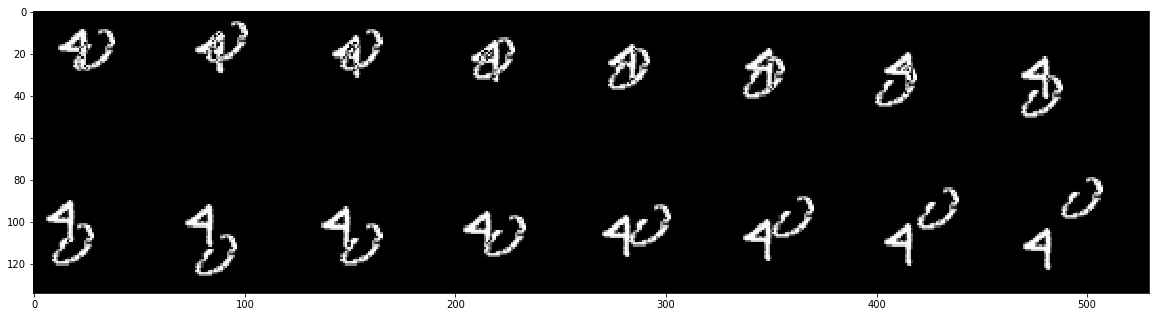

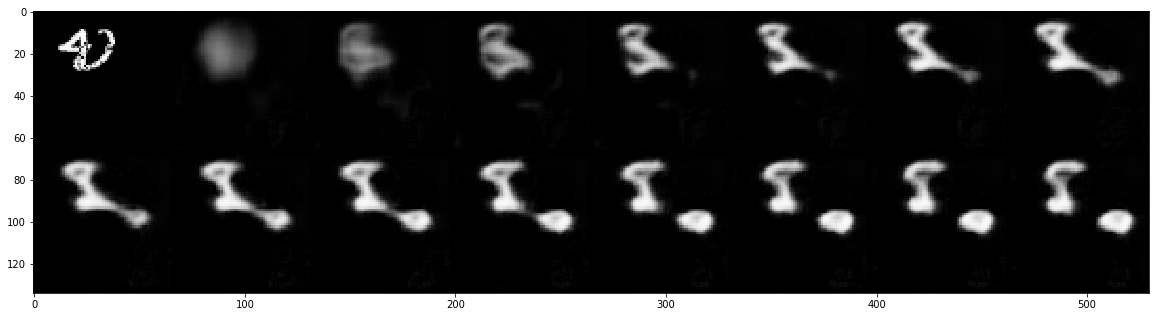

In [86]:
print ('Train set performance, eval mode:')
test_lstm_eval(train_loader)

Train set performance, train mode:


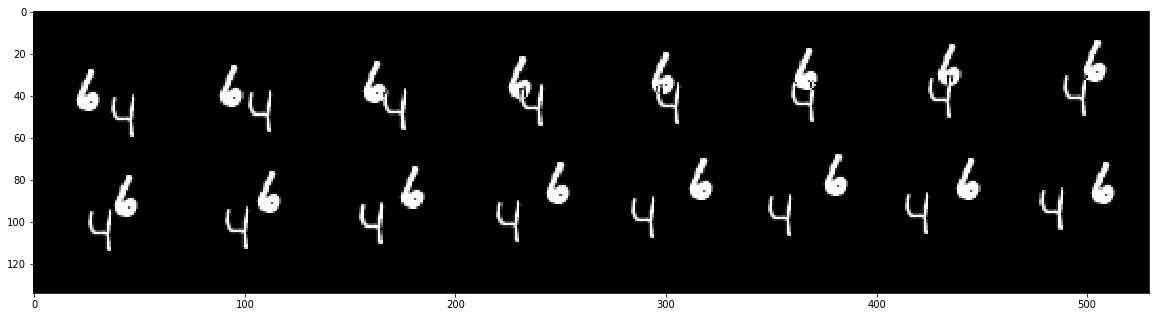

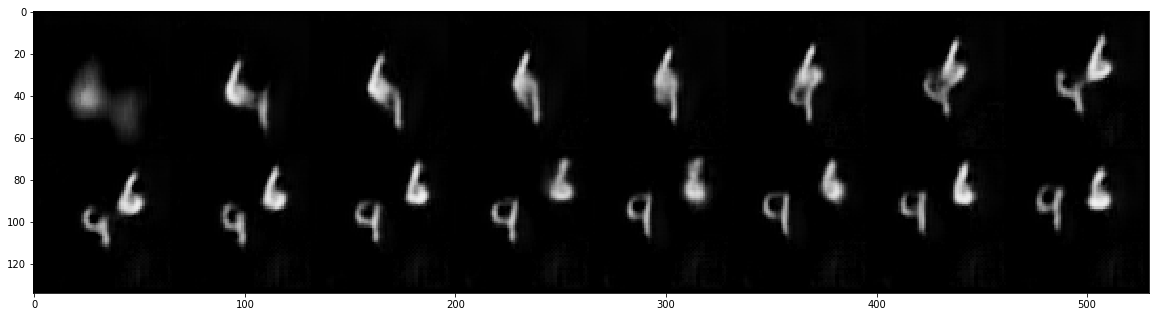

In [87]:
print ('Train set performance, train mode:')
test_lstm_train(train_loader)